# Configure Phenotype Process Params

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## SET PARAMETERS

### Fixed parameters for SBS processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from microfilm import microplot
from microfilm.microplot import Micropanel

from lib.shared.file_utils import get_filename, read_stack
from lib.shared.illumination_correction import apply_ic_field
from lib.sbs_process.segment_cellpose import segment_cellpose
from lib.sbs_process.configuration_utils import (
    annotate_on_phenotyping_data,
    identify_cytoplasm_cellpose,
)

## Helper Functions

In [3]:
# Custom function to create segmentation colormap
def random_cmap(alpha=0.5, num_colors=256):
    """Create random colormap for segmentation."""
    colmat = np.random.rand(num_colors, 4)
    colmat[:, -1] = alpha
    # Set the first color to black with full transparency
    colmat[0, :] = [0, 0, 0, 1]
    cmap = matplotlib.colors.ListedColormap(colmat)
    return cmap

## SET PARAMETERS

### Parameters for testing SBS processing

- `TEST_WELL`, `TEST_TILE`: Well/tile combination used for configuring parameters in this notebook.

In [4]:
TEST_WELL = "A1"
TEST_TILE = 1

WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

Loading test image...
Applying illumination correction...
Example corrected image:


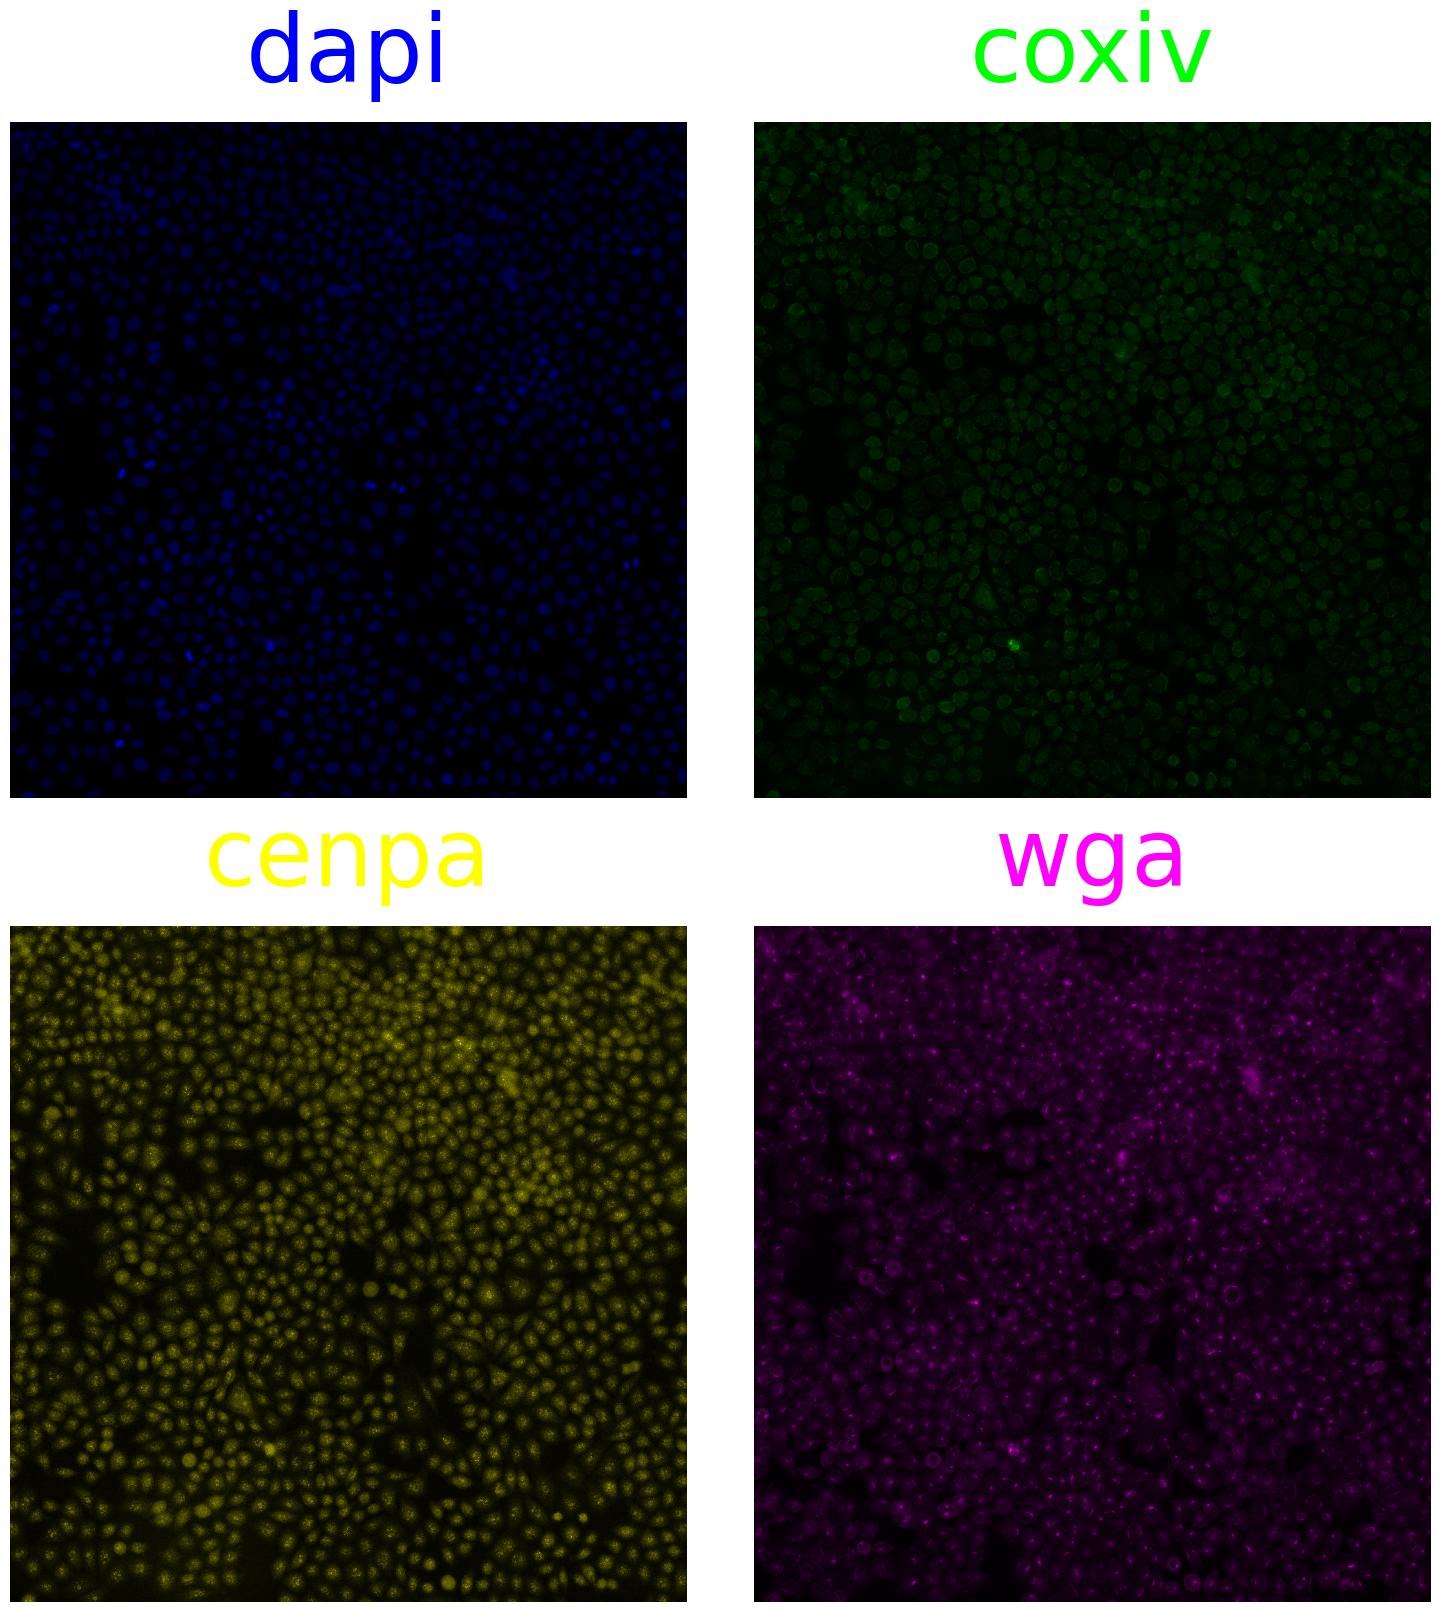

In [5]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = read_stack(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = read_stack(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# show corrected
print("Example corrected image:")
ph0_microshow = microplot.Microimage(
    corrected_image[0], cmaps="pure_blue", channel_names="dapi"
)
ph1_microshow = microplot.Microimage(
    corrected_image[1], cmaps="pure_green", channel_names="coxiv"
)
ph2_microshow = microplot.Microimage(
    corrected_image[2], cmaps="pure_yellow", channel_names="cenpa"
)
ph3_microshow = microplot.Microimage(
    corrected_image[3], cmaps="pure_magenta", channel_names="wga"
)
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0, 0], ph0_microshow)
panel.add_element([0, 1], ph1_microshow)
panel.add_element([1, 0], ph2_microshow)
panel.add_element([1, 1], ph3_microshow)
panel.add_channel_label()
plt.show()

## SET PARAMETERS

### Segmentation

- `DAPI_INDEX`: The index of the DAPI channel in your image stack (0-indexed). Typically 0 for the DAPI channel from sequencing.
- `CYTO_CHANNEL`: The index of the cytoplasmic channel in your image stack (0-indexed). Typically the channel that best outlines cell boundaries, usually base C.
- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

In [6]:
# Parameters for CellPose segmentation
DAPI_INDEX = 0
CYTO_CHANNEL = 1
NUCLEI_DIAMETER = 47.1
CELL_DIAMETER = 55.3
CYTO_MODEL = "cyto3"

In [7]:
print("Segmenting cells...")
nuclei, cells = segment_cellpose(
    data=corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_CHANNEL,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cyto_model=CYTO_MODEL,
)

Segmenting cells...


/opt/homebrew/anaconda3/envs/brieflow_configuration/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)
/opt/homebrew/anaconda3/envs/brieflow_configuration/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializati

removing edges


found 1170 nuclei before reconciling
found 1137 cells before reconciling


reconciling masks with method how=consensus


found 1108 nuclei/cells after reconciling


Number of nuclei segmented: 1108
Number of cells segmented: 1108


Example microplots for DAPI channel and nuclei segmentation:


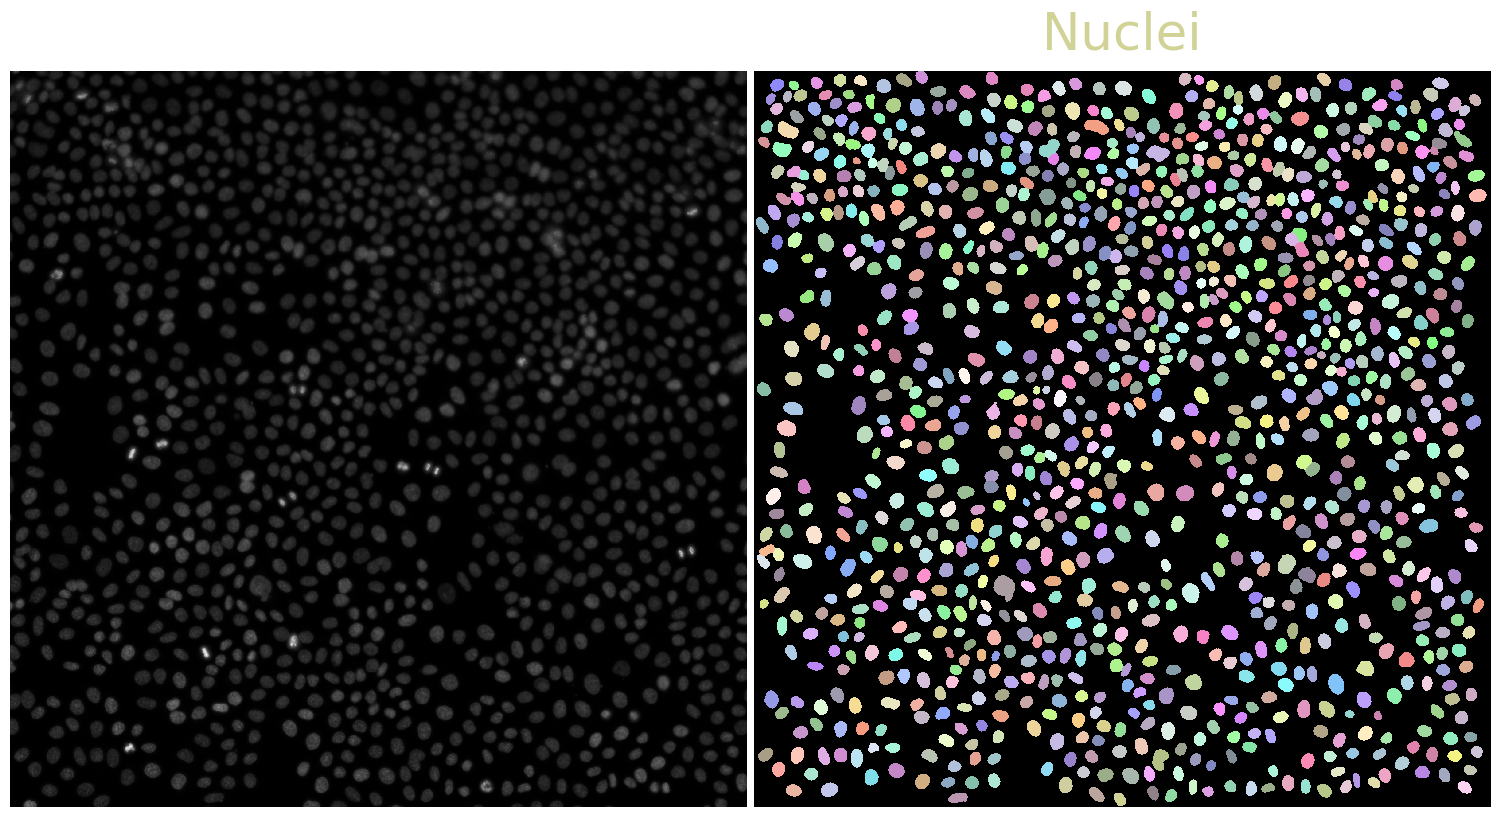

Example microplots for merged channels and cells segmentation:


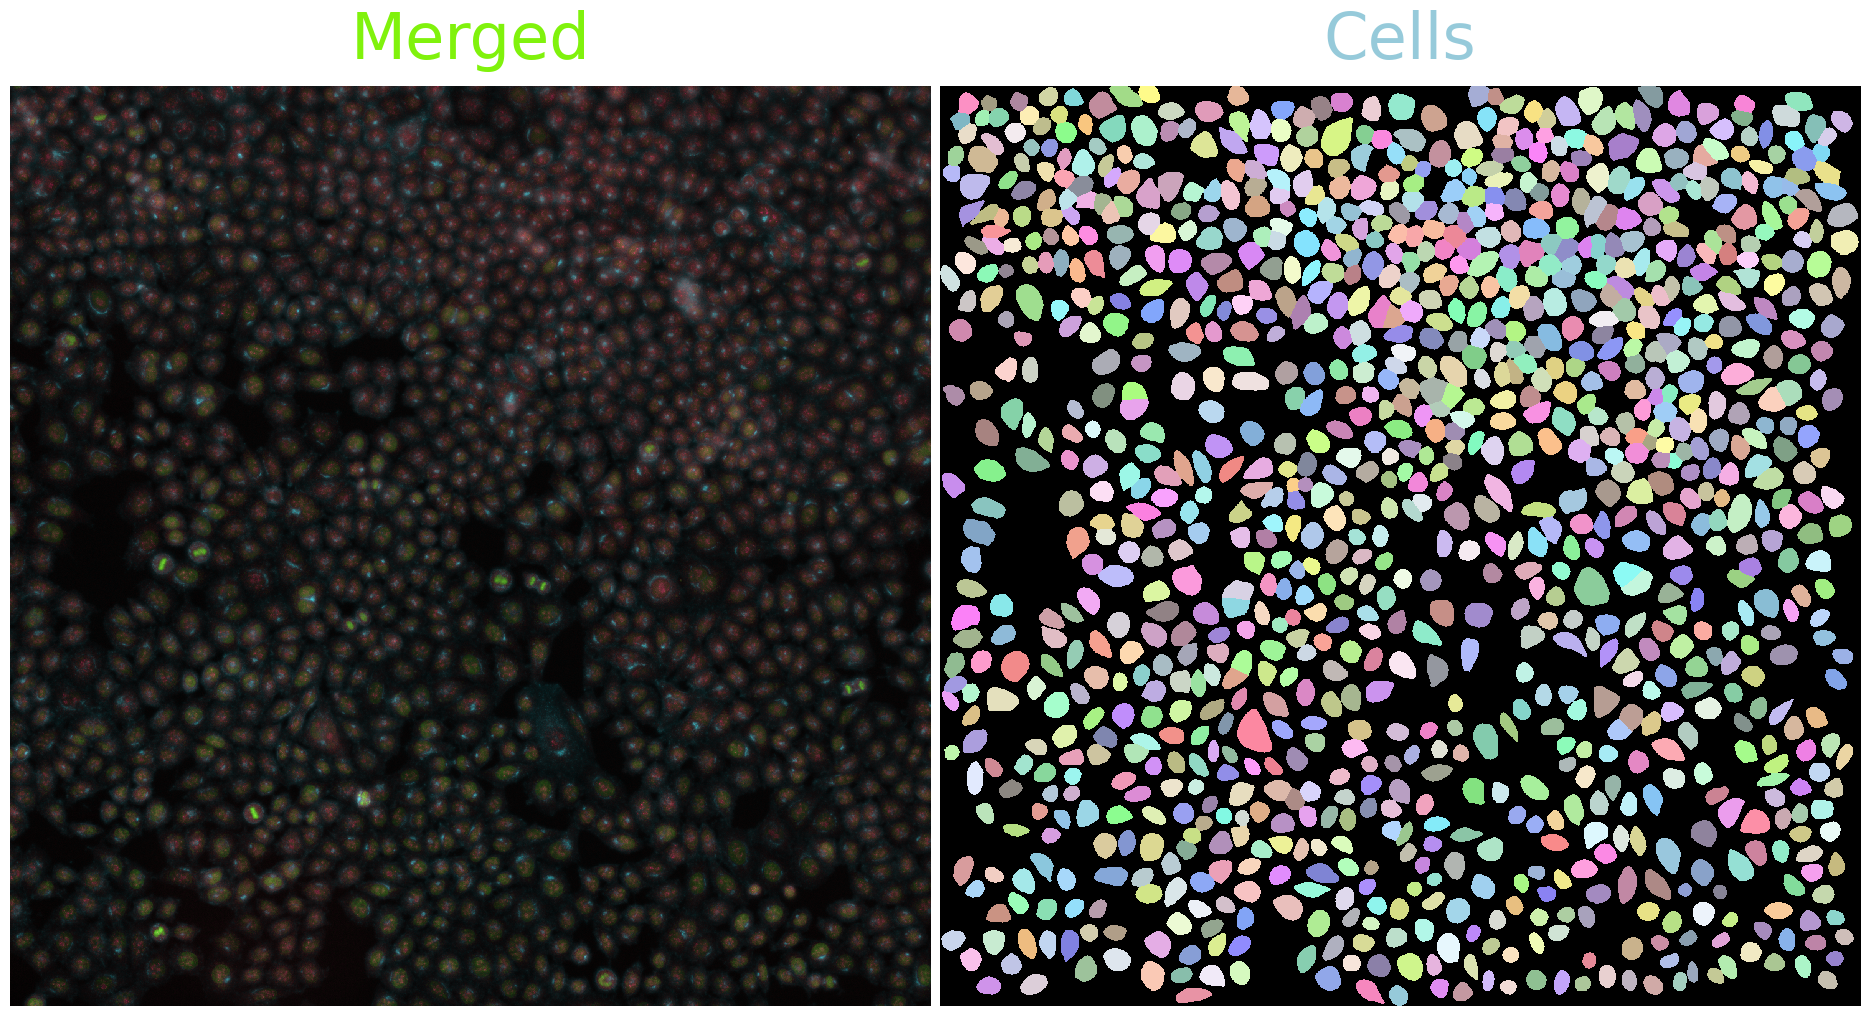

Example microplot for phenotype data annotated with segmenation:


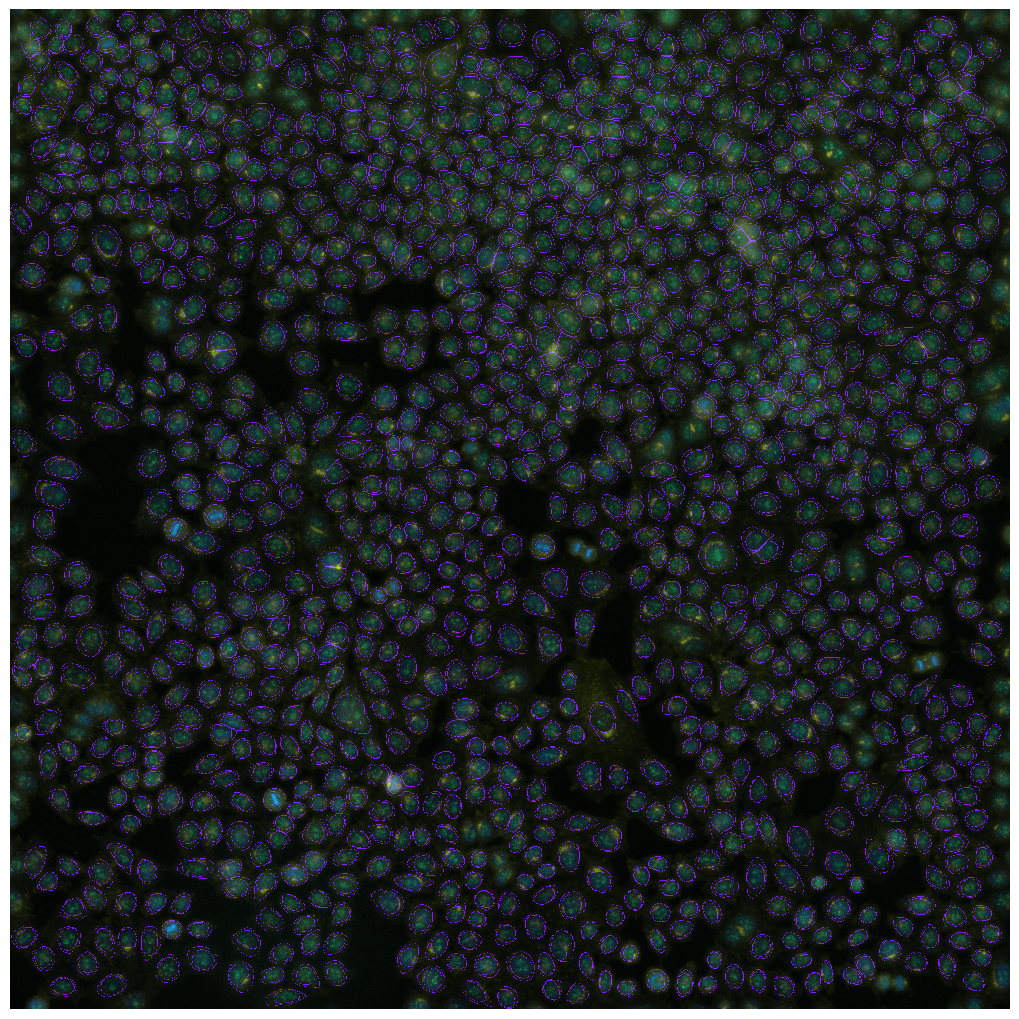

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 1108


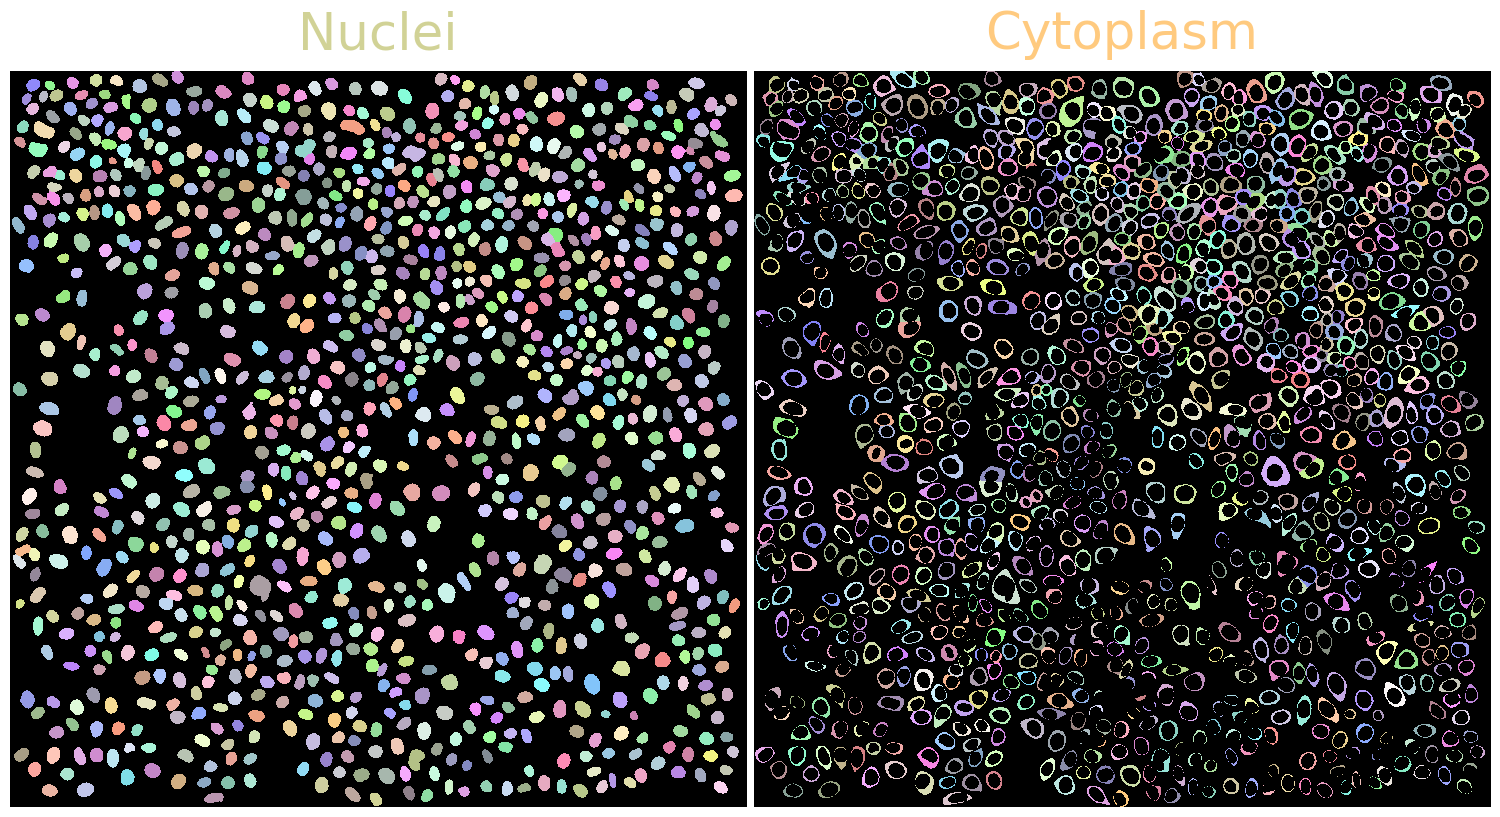

In [8]:
print("Example microplots for DAPI channel and nuclei segmentation:")
dapi_microshow = microplot.Microimage(corrected_image[DAPI_INDEX], channel_names="Dapi")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(
    nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], dapi_microshow)
panel.add_element([0, 1], nuclei_microshow)
panel.add_channel_label()
plt.show()

print("Example microplots for merged channels and cells segmentation:")
all_microshow = microplot.Microimage(corrected_image, channel_names="Merged")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells, cmaps=cells_cmap, channel_names="Cells")
panel = Micropanel(rows=1, cols=2, figscaling=10)
panel.add_element([0, 0], all_microshow)
panel.add_element([0, 1], cells_microshow)
panel.add_channel_label()
plt.show()

print("Example microplot for phenotype data annotated with segmenation:")
annotated_data = annotate_on_phenotyping_data(corrected_image, nuclei, cells)
annotated_microshow = microplot.Microimage(annotated_data, channel_names="Merged")
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0, 0], annotated_microshow)
plt.show()

print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasm_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasm_microshow = microplot.Microimage(
    cytoplasms, cmaps=cytoplasm_cmap, channel_names="Cytoplasm"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], nuclei_microshow)
panel.add_element([0, 1], cytoplasm_microshow)
panel.add_channel_label()
plt.show()

## SET PARAMETERS

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.

In [9]:
# Define CellPose parameters
FOCI_CHANNEL = 1
CHANNEL_NAMES = ["dapi", "coxiv", "cenpa", "wga"]

In [10]:
print("Extracting multichannel CP features...")
df_ph = extract_phenotype_cp_multichannel(
    data_phenotype=corrected_image,
    nuclei=nuclei,
    cells=cells,
    wildcards=WILDCARDS,
    cytoplasms=cytoplasms,
    foci_channel=FOCI_CHANNEL,
    channel_names=CHANNEL_NAMES,
)
df_ph.to_csv(
    name(description, tag="phenotype", ext="csv", subdir=OUTPUT_FILES_DIR), index=None
)
display(df_ph)

# Generate a summary of the number of cells
plot_count_heatmap(df_ph_info, shape="6W_sbs", return_plot=False, return_summary=True)

Extracting multichannel CP features...


NameError: name 'extract_phenotype_cp_multichannel' is not defined